# Bayesian Linear Regression

As the Maximum Likelihood Estimation (MLE) suffers from over-fitting, we mooved to the Maximum A Posteriori (MAP) which takes into account a prior on the parameter $\theta$ and return the one that maximises the posterior.

A further approach is to derive the probabilistic distribution of the posterior and sample directly from it.

\begin{align*}
p(\theta|y) = \frac{p(y,\theta)}{p(y)}
\end{align*}

As shown above, this requires to compute the marginal likelihood, which can be expressed:

\begin{align*}
p(y) = \int p(y,\theta)d\theta
\end{align*}

If we choose a conjugate parameter prior $p(\theta)$, we can compute the marginal likelihood in closed form. It is generally intractable though, so numerical approches (Monte Carlo) may be required.

In this example, we consider the following linear regression problem, where $\Phi$ defines the features, and $\epsilon$ is a Gaussian $\mathcal{N}(0,\beta I)$:

\begin{align*}
y = \Phi^T(x)\theta + \epsilon
\end{align*}

In addition, we choose the prior on $\theta$ to be a Gaussian $\mathcal{N}(0,\alpha I)$

The joint distribution can now easily be expressed:

\begin{align*}
p(y, \theta) = \mathcal{N}(y|\Phi^T \theta, \beta I) \mathcal{N}(\theta|0, \alpha I)
\end{align*}

The idea is to find the best $\alpha$ and $\beta$ to maximise the marginal likelihood. A commum way is to derive the expression of the negative log marginal likelihood and try to minimise it by a gradient method descent.

As said above, since we have choosen a conjugate prior, a closed form solution for the marginal likelihood can be found. Using the fact that the product of two Gaussians is an unormalised Gaussian, and in calculating both the mean and the variance of the obtained Gaussian, it can be shown that:

\begin{align*}
p(y) & = \int \mathcal{N}(y|\Phi^T \theta, \beta I) \mathcal{N}(\theta|0, \alpha I)\\
& =\frac{1}{(2\pi)^{\frac{N}{2}}|\alpha \Phi \Phi^T + \beta I|^{\frac{1}{2}}}\exp \left(-\frac{1}{2}y^T(\alpha \Phi \Phi^T + \beta I)^{-1} y \right)
\end{align*}

Taking the negative log:

\begin{align*}
-\log p(y) =\frac{N}{2} \log 2\pi + \frac{1}{2} \log|\alpha \Phi \Phi^T + \beta I| + \frac{1}{2}y^T(\alpha \Phi \Phi^T + \beta I)^{-1} y
\end{align*}

The partial derivatives with respect to $\alpha$ and $\beta$ can be calculated:

\begin{align*}
\frac{\partial -\log p(y)}{\partial \alpha} &= \frac{1}{2} \mathrm{Tr} ((\alpha \Phi \Phi^T + \beta I)^{-1} \Phi) - \frac{1}{2} y^T (\alpha \Phi \Phi^T + \beta I)^{-1} \Phi (\alpha \Phi \Phi^T + \beta I)^{-1}  y \\
\frac{\partial -\log p(y)}{\partial \beta} &= \frac{1}{2} \mathrm{Tr} ((\alpha \Phi \Phi^T + \beta I)^{-1}) - \frac{1}{2} y^T(\alpha \Phi \Phi^T + \beta I)^{-1} (\alpha \Phi \Phi^T + \beta I)^{-1} y \\
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 25
X = np.reshape(np.linspace(0, 0.9, N), (N, 1))
Y = np.cos(10*X**2) + 0.1 * np.sin(100*X)
x_test = np.linspace(-1,1.3,1000)

In [3]:
def phi(n, x, kernel):
    if kernel==1: #poly
        D=np.array([x**i for i in range(n+1)]).flatten()
    elif kernel==2: #trigo
        D=np.array([np.cos(2*np.pi*i/2*x) if i%2==0 else np.sin(2*np.pi*(i+1)/2*x) for i in range(2*n+1)]).flatten()
    elif kernel==3: #gauss
        D=np.array([])
        D=np.append(D, 1)
        value=np.linspace(-.5,1,n)
        D=np.append(D, [np.exp(-(x-mean)**2/(2*0.1**2)) for mean in value]).flatten()
    return D

def phi_mat(n, X, kernel):
    size=n+1
    if kernel==2:
        size=2*n+1    
    return np.array([phi(n,x, kernel) for x in X ]).reshape(len(X),size)

In [4]:
def lml(alpha, beta, Phi, Y):
    ly=len(Y)
    A=alpha*np.dot(Phi,np.transpose(Phi))+beta*np.eye(ly)
    return (-np.log((2*np.pi)**(ly/2.)*np.linalg.det(A)**(1/2.))-1/2.*np.dot(np.dot(np.transpose(Y), np.linalg.inv(A)), Y))[0][0]
    

def grad_lml(alpha, beta, Phi, Y):
    ly=len(Y)
    A=alpha*np.dot(Phi,np.transpose(Phi))+beta*np.eye(ly)
    matPhi=np.dot(Phi, np.transpose(Phi))
    matA=np.dot(np.linalg.inv(A), np.dot(matPhi, np.linalg.inv(A)))
    grad1=(-1/2.*np.trace(np.dot(np.linalg.inv(A), matPhi))+1/2.*np.dot(np.transpose(Y), np.dot(matA, Y)))[0][0]
    grad2=(-1/2.*np.trace(np.linalg.inv(A))+1/2.*np.dot(np.transpose(Y), np.dot(np.linalg.inv(A), np.dot(np.linalg.inv(A), Y))))[0][0]
    
    return np.array([grad1, grad2])
    
def grad_descent(gamma, nb, epsilon, alpha_0, beta_0, Phi, Y):
    alpha_old = alpha_0
    beta_old = beta_0
    Lx = [alpha_0]
    Ly = [beta_0]
    Ls = [lml(alpha_0, beta_0, Phi, Y)]
    alpha_new = alpha_old + gamma * grad_lml(alpha_old, beta_old, Phi, Y)[0]
    beta_new = beta_old + gamma * grad_lml(alpha_old, beta_old, Phi, Y)[1]
    alpha_old = alpha_new
    beta_old = beta_new
    Lx.append(alpha_new)
    Ly.append(beta_new)
    Ls.append(lml(alpha_new, beta_new, Phi, Y))
    i=0
    while i < nb and (abs(Lx[-2]-Lx[-1]) > epsilon or abs(Ly[-2]-Ly[-1]) > epsilon):
        alpha_new = alpha_old + gamma * grad_lml(alpha_old, beta_old, Phi, Y)[0]
        beta_new = beta_old + gamma * grad_lml(alpha_old, beta_old, Phi, Y)[1]
        alpha_old = alpha_new
        beta_old = beta_new
        Lx.append(alpha_new)
        Ly.append(beta_new)
        Ls.append(lml(alpha_new, beta_new, Phi, Y))
        i+=1
    return Lx, Ly, Ls

Text(0, 0.5, 'beta')

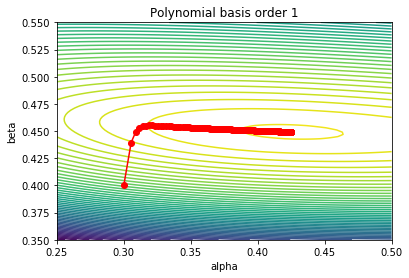

In [5]:
nb_iter = 1000
epsilon = 0.00000001
alpha_0 = .3
beta_0 = .4
kernel = 1
order = 1
step_size = .01

alphalist = np.linspace(.25, .5, 100)
betalist = np.linspace(.35, .55, 100)
Z = [[0 for i in range(100)] for j in range(100)]

for i in range(100):
    for j in range(100):
        Z[i][j] = lml(alphalist[j], betalist[i], phi_mat(order, X, kernel), Y)

plt.contour(alphalist, betalist, Z, 50)
plt.plot(grad_descent(step_size, nb_iter, epsilon, alpha_0, beta_0, phi_mat(order, X, kernel), Y)[0], grad_descent(step_size, nb_iter, epsilon, alpha_0, beta_0, phi_mat(order, X, kernel), Y)[1], marker="o", color="red")
plt.title("Polynomial basis order 1")
plt.xlabel('alpha')
plt.ylabel('beta')

In this case, the maximum of the log marginal likelihood is -27.61,reached for the value $(\alpha, \beta) = (0.42, 0.45)$.

This is also a way to do model selection, in comparing the value of the max log marginal likelihood for different orders of the polynomial basis.

In [6]:
nb_iter = 100000
kernel = 2
value_alpha = []
value_beta = []
value_max = []
for i in range(11):
    if i < 4:
        step = 0.00001
    else:
        step = 0.000001
    a = grad_descent(step, nb_iter, epsilon, alpha_0, beta_0, phi_mat(i, X, kernel), Y)
    print(np.shape(a[2]))
    value_alpha.append(a[0][-1])
    value_beta.append(a[1][-1])
    value_max.append(a[2][-1])

(27063,)
(34177,)
(13874,)
(7153,)
(37101,)
(25509,)
(17868,)
(18997,)
(21093,)
(25499,)
(33839,)


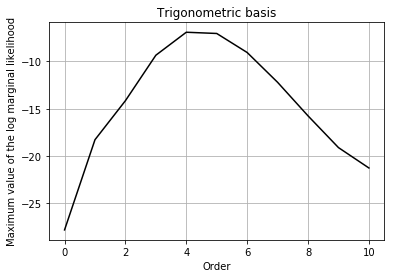

In [7]:
plt.plot(value_max, color="black")
plt.xlabel("Order")
plt.ylabel("Maximum value of the log marginal likelihood")
plt.title("Trigonometric basis")
plt.grid()

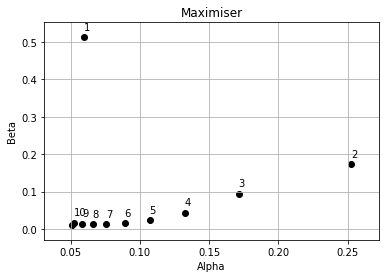

In [8]:
plt.scatter(value_alpha, value_beta, color="black")
for i in range(10):
    plt.annotate(i+1, (value_alpha[i], value_beta[i]+0.02))
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.title("Maximiser")
plt.grid()

The value is maximum for orders 4 and 5. This is an indication of the proper order to choose. It could have been possible to use cross validation to find this result.

The Bayesian is more robust to over-fitting, since there is no totally non relevant results at
high orders as it was for the CV.

One the other hand, the CV is easy mathematical speaking and more versatile since it can
be applied to a variety of models.

Getting back to the original problem. The idea is to make sample from the posterior distribution. In the case of conjugate Gaussian prior, the posterior distribution can be expressed:

\begin{align*}
p(y) & = \int \mathcal{N}(y|\Phi^T \theta, \beta I) \mathcal{N}(\theta|0, \alpha I)\\
& =\frac{1}{(2\pi)^{\frac{N}{2}}|\alpha \Phi \Phi^T + \beta I|^{\frac{1}{2}}}\exp \left(-\frac{1}{2}y^T(\alpha \Phi \Phi^T + \beta I)^{-1} y \right)
\end{align*}

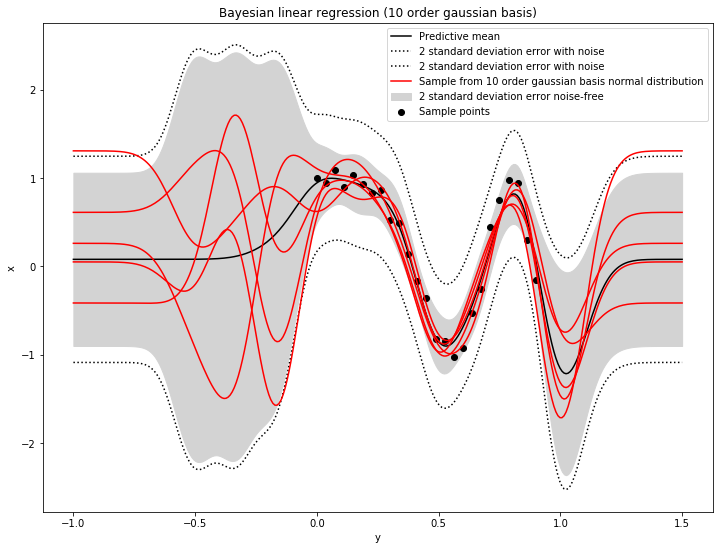

In [9]:
def gauss_function(alpha, beta, Phi, Y):
    SN = np.linalg.inv(1/alpha*np.eye(Phi.shape[1]) + 1/beta*np.dot(np.transpose(Phi), Phi))
    MN = np.dot(SN, 1/beta*np.dot(np.transpose(Phi), Y))
    
    S = np.random.multivariate_normal(MN.flatten(), SN, 5)
    
    return S, MN, SN
    
kernel = 3
order = 10
alpha = 1
beta = 0.1
    
X_test = np.reshape(np.linspace(-1, 1.5, 300), (300, 1))
phi_test = phi_mat(order, X_test, kernel)
predictive_mean = np.dot(phi_test, gauss_function(alpha, beta, phi_mat(order, X, kernel), Y)[1])
deviation_error = np.sqrt(np.diag(np.dot(phi_test, np.dot(gauss_function(alpha, beta, phi_mat(order, X, kernel), Y)[2], np.transpose(phi_test))))).reshape(300, 1)
deviation_error_noise = np.sqrt(np.diag(np.dot(phi_test, np.dot(gauss_function(alpha, beta, phi_mat(order, X, kernel), Y)[2], np.transpose(phi_test)))+.1*np.eye(300))).reshape(300, 1)

plt.figure(3, figsize=(12,9))
plt.fill_between(X_test.flatten(), (predictive_mean + 2*deviation_error).flatten(), (predictive_mean - 2*deviation_error).flatten(), color='lightgrey', label='2 standard deviation error noise-free')
plt.plot(X_test, predictive_mean, label='Predictive mean', color='black')
plt.plot(X_test, predictive_mean + 2*deviation_error_noise, linestyle=':', label='2 standard deviation error with noise', color='black')
plt.plot(X_test, predictive_mean - 2*deviation_error_noise, linestyle=':', label='2 standard deviation error with noise', color='black')
plt.plot(X_test, np.dot(phi_test, gauss_function(1, 0.1, phi_mat(order, X, kernel), Y)[0][0]), label='Sample from 10 order gaussian basis normal distribution', color='red')
for i in range(1, len(gauss_function(1, 0.1, phi_mat(order, X, kernel), Y)[0])):
    plt.plot(X_test, np.dot(phi_test, gauss_function(1, 0.1, phi_mat(order, X, kernel), Y)[0][i]), color='red')
plt.scatter(X, Y, color='black', label='Sample points')
plt.xlabel('y')
plt.ylabel('x')
plt.title('Bayesian linear regression (10 order gaussian basis)')
plt.legend()
